This notebook recreates the following example using BET:  
http://madsjulia.github.io/Mads.jl/Examples/infogap/  
See the introduction of the documentation therein for more information about the problem setup. 

Author: Michael Pilosov  
Date: 06-09-2017

In [1]:
# Import modules
import numpy as np
import bet.calculateP.simpleFunP as simpleFunP
import bet.calculateP.calculateP as calculateP
import bet.postProcess.plotP as plotP
import bet.postProcess.plotDomains as plotD
import bet.sample as samp
import bet.sampling.basicSampling as bsam
from myModel import my_model2 as my_model

import time
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [12]:
num_input_samples = 2E5 # Note 20,000 samples is similar to what the regular grid would use
randomSampling = True # random or regular sampling?
grid_factor = 50 # for regular sampling only. how many per interval.

Define reference parameter. Recall that  
$$
y(t) = a t + c
$$

The convention of ordering for our parameter $\lambda$ that we will use is  
$$
\lambda = [a, c]
$$

Since the data we are trying to match up for $t = [1,2,3,4]$ is $y(t) = [1,2,3,4]$, then we have one solution  

$$
a=1, \quad c=0
$$

However, we do have a choice of data space to use (any two of the four observations. However, there's not going to be any real difference between any of them. _Verify this later_

In [13]:
ref_param = np.array([[1.0, 0.0]])
Q_ref =  my_model(np.array(ref_param))
print ref_param[0], '=>', Q_ref[0]

[ 1.  0.] => [ 1.  2.  3.  4.]


In [14]:
sampler = bsam.sampler(my_model)
input_samples = samp.sample_set(2) # 2 dimensional space
input_samples.set_domain(np.array([ [-10.0, 10.0],
                                    [-5.0, 5.0]]))

if randomSampling is True:
    input_samples = sampler.random_sample_set('random', input_samples, num_samples=num_input_samples)
else:
    # if regular sampling, use the integer grid in uncertainty box. 24,000 samples.
    input_samples = sampler.regular_sample_set(input_samples, num_samples_per_dim=grid_factor*np.array([20, 10])) 


A standard Monte Carlo (MC) assumption is that every Voronoi cell has the same volume. If a regular grid of samples was used, then the standard MC assumption is true. If the number of random samples is large enough for the dimension of the parameter space, the MC assumption is _practically_ true. To have accurate volumes of the randomly generated Voronoi cells, we can use emulation. 

In [15]:
MC_assumption = True
start_time = time.time()
# Estimate volumes of Voronoi cells associated with the parameter samples
if MC_assumption is False:
    input_samples.estimate_volume(n_mc_points=num_input_samples*50.0)
else:
    input_samples.estimate_volume_mc()

# Create the discretization object using the input samples
my_full_discretization = sampler.compute_QoI_and_create_discretization(input_samples,
                                               savefile = '2to2_discretization.txt.gz')
end_time = time.time()

In [16]:
print 'time elapsed:', (end_time - start_time)/60
print 'number of unique volumes:', np.unique(my_full_discretization._input_sample_set._volumes).shape[0]

time elapsed: 0.0077951669693
number of unique volumes: 1


Next, we define a distribution on our output space, which is $\pm 1$ in each dimension. The argument `rect_size` refers to the length of the interval, which will thus be 2. The number of cells per dimension raised to the fourth power will determine the number of unique probabilities over the support of the inverse image.  
Finally, we calculate the probability measure over the parameter space $\Lambda$.

In [21]:
QoI_indices = [0,3]
h = 1
output_disc_cells_per_dim = 5
randomDataDiscretization = False

# # #
output_samples = my_full_discretization._output_sample_set.copy() # grab subset of QoI indices
output_samples._dim = len(QoI_indices)
output_samples.set_values(output_samples._values[:, QoI_indices])    
output_samples.global_to_local()

my_discretization = samp.discretization(input_sample_set=input_samples,
                                            output_sample_set=output_samples)

if randomDataDiscretization is False:
    simpleFunP.regular_partition_uniform_distribution_rectangle_size(
            data_set=my_discretization, Q_ref=Q_ref[0][QoI_indices], rect_size=2.0*h,
            cells_per_dimension = output_disc_cells_per_dim)
else:
    simpleFunP.uniform_partition_uniform_distribution_rectangle_size(
        data_set=my_discretization, Q_ref=Q_ref[0][QoI_indices], rect_size=2.0*h,
        M=50, num_d_emulate=1E5)
    
calculateP.prob(my_discretization)

In [18]:
# Extrapolate to t=5 # 
samples_nonzero = input_samples._values[input_samples._probabilities>0]
extrapolation = samples_nonzero[:,0]*5.0 + samples_nonzero[:,1]
print 'Model at t=5, (min, max):', np.min(extrapolation), np.max(extrapolation) 
print '\t\t   range:', np.max(extrapolation)-np.min(extrapolation)

Model at t=5, (min, max): 3.36774711568 6.61992396702
		   range: 3.25217685133


In [22]:
print sum(my_discretization._input_sample_set._probabilities)


1.0


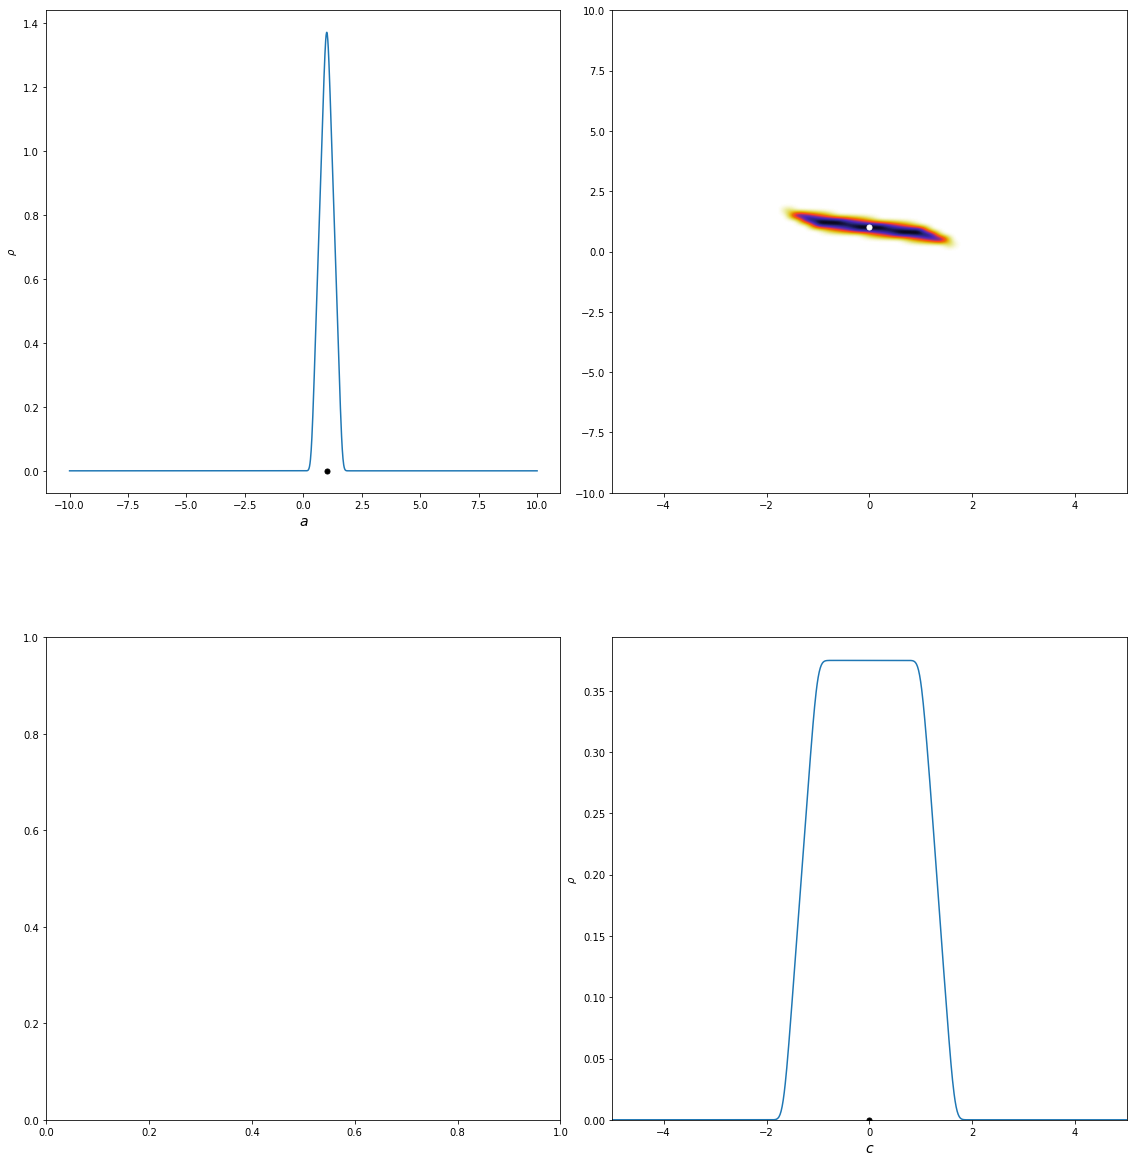

In [153]:
plot_disc = 100 # plotting discretization

# calculate 2d marginal probs
(bins2D, marginals2D) = plotP.calculate_2D_marginal_probs(input_samples,
                                                        nbins = plot_disc*np.ones(4))

# smooth 2d marginals probs (optional)
# marginals2D = plotP.smooth_marginals_2D(marginals2D, bins, sigma=0.2)

# plot 2d marginals probs
plotP.plot_2D_marginal_probs(marginals2D, bins2D, input_samples, filename = "linearMap",
                             lam_ref=ref_param[0], file_extension = ".eps", plot_surface=False)

# calculate 1d marginal probs
(bins1D, marginals1D) = plotP.calculate_1D_marginal_probs(input_samples,
#                                                         nbins = plot_disc*np.ones(4))
                                                        nbins = plot_disc*np.array([20, 10]))
# smooth 1d marginal probs (optional)
marginals1D = plotP.smooth_marginals_1D(marginals1D, bins1D, sigma=0.1)

plt.rcParams['figure.figsize'] = (16, 16)
lambda_label = ['a','c']
f, ax = plt.subplots(2,2)
for i in xrange(2):
    for j in xrange(2):
        lam_domain = input_samples.get_domain()
        if i==j:
            x_range = np.linspace(lam_domain[i, 0], lam_domain[i, 1],
                    len(bins1D[i])-1)
            ax[i,j].plot(x_range, marginals1D[i]/(bins1D[i][1]-bins1D[i][0]))
#             ax[i,j].set_ylim([0, 1.05*np.max(marginals1D[i]/(bins1D[i][1]-bins1D[i][0]))])
            plt.axis([lam_domain[i][0], lam_domain[i][1], 
                      0, 1.05*np.max(marginals1D[i]/(bins1D[i][1]-bins1D[i][0]))])
            ax[i,j].plot(ref_param[0,i], 0.0, 'ko', markersize=5)
            ax[i,j].set_ylabel(r'$\rho$')
            ax[i,j].set_xlabel(r'$%s$'%lambda_label[i],fontsize=14)
            
        elif i<j:
#             ax[i,j].scatter(marginals1D[i], marginals1D[j])
            boxSize = (bins2D[i][1]-bins2D[i][0])*(bins2D[j][1]-bins2D[j][0])
            ax[i,j].imshow(marginals2D[(i,j)]/boxSize, 
                          interpolation='bicubic', cmap=cm.CMRmap_r, 
                          extent=[lam_domain[j][0], lam_domain[j][1],
                          lam_domain[i][0], lam_domain[i][1]], origin='lower',
                          vmax=marginals2D[(i, j)].max()/boxSize, vmin=0, aspect='auto')
            ax[i,j].plot(ref_param[0,j], ref_param[0,i], 'wo', markersize=5)
            plt.axis([lam_domain[i][0], lam_domain[i][1], lam_domain[j][0],
                lam_domain[j][1]])
            plt.tight_layout()
#             ax[i,j].set_ylabel(r'$%s$'%lambda_label[j])
        
f.subplots_adjust(hspace=0.3)
plt.show()

_With the horizon of uncertainty at h=1.0: _  

Using the observations at t=1 and t=4, the range at t=5 was 3.28. This represents a best case scenario.  
Using the observations at t=1 and t=2, the range was 13.92.  
Using the observations at t=1 and t=3, the range was 5.92.  
Using the observations at t=2 and t=3, the range was 9.86.  
Using the observations at t=3 and t=4, the range was 4.96.  

In [122]:
# plt.scatter(marginals1D[0],marginals1D[3])
# plt.show()
print 'unique probs:', np.unique(input_samples._probabilities)
print '%2.2f%% of samples have positive \
probability.'%(100./np.unique(input_samples._probabilities)[1::][0]/input_samples.check_num())

unique probs: [ 0.          0.00029197  0.00029197  0.00029412  0.00029412  0.0002963
  0.0002963   0.0002963   0.00029851  0.00029851  0.00029851  0.00029851
  0.00029851  0.00030075  0.00030075  0.00030303  0.00030303  0.00030303
  0.00030303  0.00030303  0.00030534  0.00030534  0.00030534  0.00031008]
0.69% of samples have positive probability.


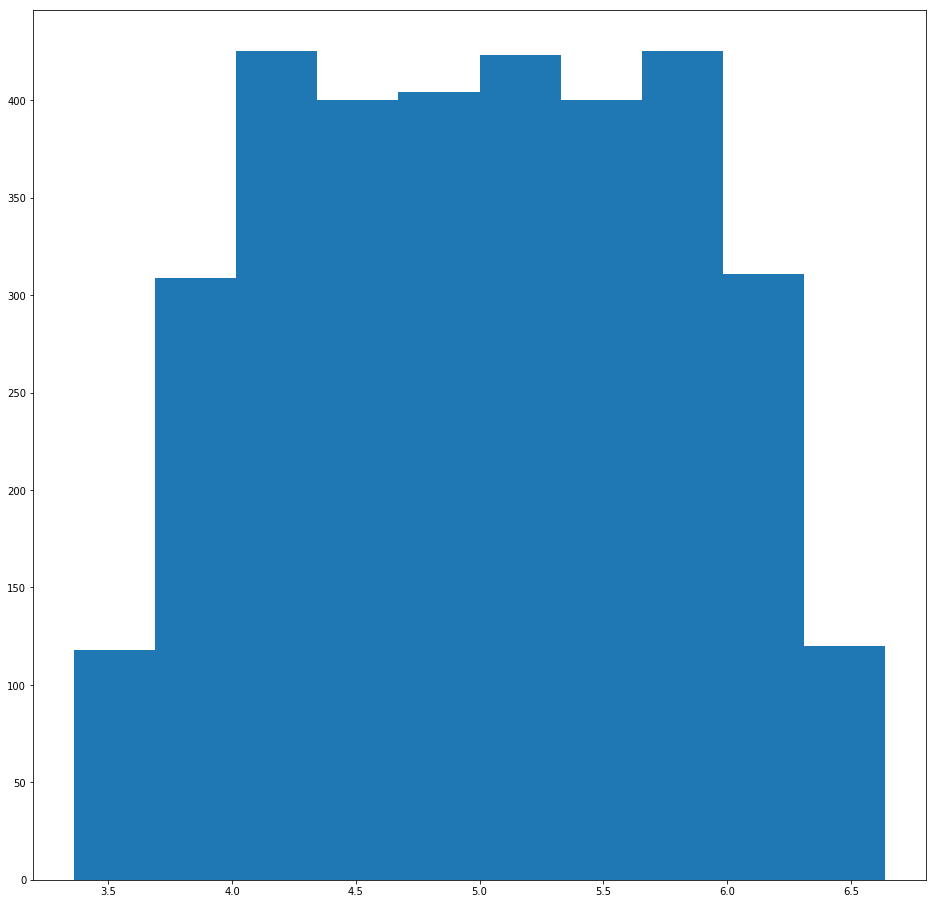

In [154]:
probs = input_samples._probabilities[input_samples._probabilities>0]
samples_nonzero
ex2=extrapolation*probs

plt.hist(extrapolation)
plt.show()